In PyTorch, images are represented as [channels, height, width], so a color image would be [3, 256, 256].

During the training we have batches of images, so the shape in the forward method will get an additional batch dimension at dim0: [batch_size, channels, height, width]; so for batch size 32: [32, 3, 256, 256].

There is also other representation of [batch_size, height, width, channels].

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


* **torchvision**	Contains datasets, model architectures and image transformations often used for computer vision problems.

* **torchvision.datasets**	Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets.

* **torchvision.models**	This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems.

* **torchvision.transforms**	Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.

* **torch.utils.data.Dataset**	Base dataset class for PyTorch.

* **torch.utils.data.DataLoader**	Creates a Python iterable over a dataset (created with torch.utils.data.Dataset).

## Dataset

FashionMNIST from torchvision.datasets

In [ ]:
train_data = datasets.FashionMNIST(
    root="data", # where to download
    train=True, # training or testing data
    download=True, # download?
    transform = ToTensor(), # how to transform
    target_transform=None # transform the labels also?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 257kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.09MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_idx = train_data.class_to_idx
class_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

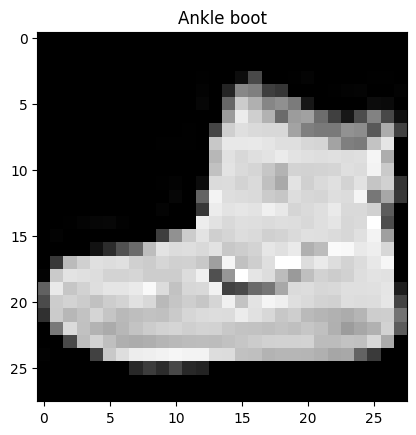

In [ ]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

In [ ]:
image.shape, label # label is just an int

(torch.Size([1, 28, 28]), 9)

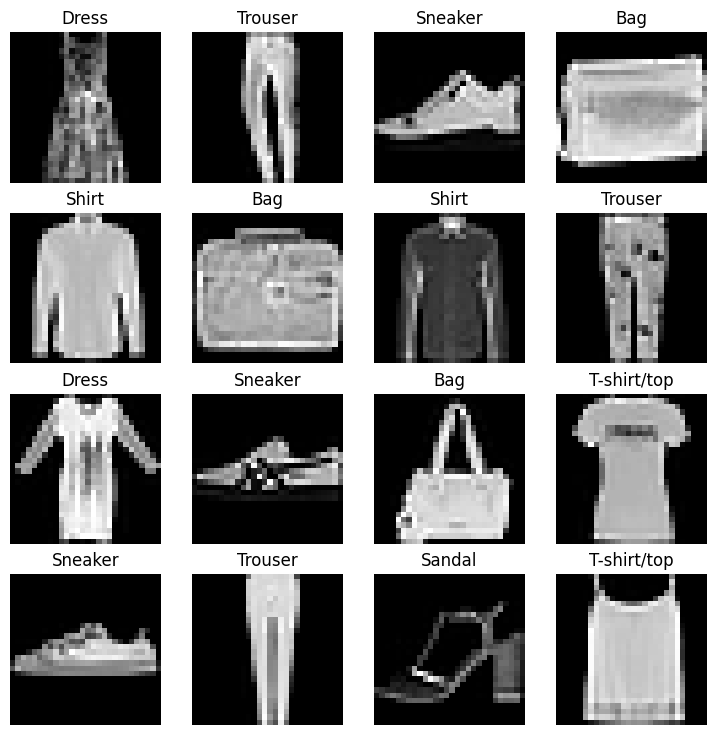

In [ ]:
# Random Image
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## Data Loader

Currently data is in form of PyTorch Dataset. DataLoader turns data into Python iterable; and turn our data into batches/mini-batches.

Mini-batch enables more updates per epoch and helps fit on computer memory.

In [ ]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a1866783150>,
 <torch.utils.data.dataloader.DataLoader at 0x7a1866792690>)

In [ ]:
print(len(train_dataloader)) # Number of batches of size BATCH_SIZE
print(len(test_dataloader))

1875
313


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Trouser')

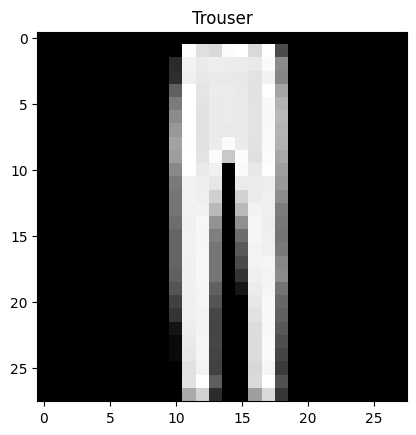

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
print(img.shape)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

## Baseline Model

Simple model to try an improve upon; start simple and add complexity as required.

In [ ]:
# Flatten Layer

flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
          nn.Flatten(), # neural networks like their inputs in vector form
          nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
          nn.Linear(in_features=hidden_units, out_features=output_shape)
      )

  def forward(self, x):
      return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Need to setup model with input parameters
model = FashionMNISTModel(input_shape=784, # one for every pixel (28x28)
                            hidden_units=10, # how many units in the hidden layer
                            output_shape=len(class_names) # one for every class
)
model.to("cpu") # keep model on CPU to begin with

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
import requests
from pathlib import Path
print("Downloading helper_functions.py")
# Note: you need the "raw" GitHub URL for this to work
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

A timing function to measure the time it takes our model to train on CPU versus using a GPU

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Since we're computing on batches of data, our loss and evaluation metrics will be calculated per batch rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it all (for fun).

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")

  # Training
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model.train()
    y_pred  = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 33.920 seconds


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device="cpu"):
  """
  Returns a dictionary with results of model prediction on data_loader.
  """

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.softmax(dim=1).argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model_results = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Better Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(), # neural networks like their inputs in vector form
      nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model = FashionMNISTModelV1(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names)).to(device)

next(model.parameters()).device

device(type='cpu')

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)
from helper_functions import accuracy_fn

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device) # Put data on device

    y_pred  = model(X)
    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc +=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%\n")


In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model, test_dataloader, loss_fn, accuracy_fn, device)


train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


Train loss: 0.98248 | Train acc: 65.06%


Test loss: 0.76060 | Test acc: 72.80%

Epoch: 1


Train loss: 0.70366 | Train acc: 74.48%


Test loss: 0.71731 | Test acc: 73.67%

Epoch: 2


Train loss: 0.67375 | Train acc: 75.31%


Test loss: 0.69170 | Test acc: 74.81%

Train time on cpu: 33.921 seconds


In [ ]:
model_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn, device=device)
model_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6917040348052979,
 'model_acc': 74.810303514377}